In [1]:
import synapseclient
import pandas as pd
import json
import csv

In [2]:
def TapPerformance(TapPD1):
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonLeft', 'TappedButtonId'] = 0
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonRight', 'TappedButtonId'] = 1
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonNone', 'TappedButtonId'] = 2
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonLeft'] = 0
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonRight'] = 1
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonNone'] = 2
    TapPD1 = Artifactfixed(TapPD1)
    TapPerf= TapPD1.shape[0]
    return (TapPerf)

In [3]:
#Index=list()
def Artifactfixed(TapCont):
    Ind =  [True] * TapCont.shape[0]
    for item in range(0,TapCont.shape[0]-1):
        if TapCont.TapCoordinate[item]==TapCont.TapCoordinate[item+1]:
            if TapCont.TappedButtonId[item]==2:
                Ind[item]=False
            elif TapCont.TappedButtonId[item+1]==2:
                Ind[item]=False
    TapContArtFixed=TapCont[Ind]
    return TapContArtFixed
          

In [7]:
Cred = open("Credentials.txt","r",encoding='utf8')
lines=Cred.readlines()
username1=lines[0][:-1]
password1=lines[1][:-1]
Cred.close()
print(username1)
print(password1)


catarivera8
Crm1061709701
catarivera8
Crm1061709701


In [8]:
syn = synapseclient.Synapse()
syn.login(username1, password1)


## QUERY THE mPower PROJECT (syn4993293) FOR ALL OF THE TABLES
# See examples: https://python-docs.synapse.org/build/html/index.html 
# and https://www.synapse.org/#!Synapse:syn4993293/discussion/threadId=6785
with open('TappingTable.csv') as csvfile:
    TapTable=pd.read_csv(csvfile, delimiter=',')
with open('DemoTable.csv') as csvfile:
    DemoTable=pd.read_csv(csvfile, delimiter=',') 
#Using Patient column (healthCode) as index for the Data frames
#TapTableB = TapTable.set_index("healthCode", drop = False) 
#DemoTableB = DemoTable.set_index("healthCode", drop = False)    

      
#TapPD = list()
PathList = list()
LabelList = list()
#PatientType = list()
#PatientList = list()
#AgeList = list()
Perform =list()
for offset in range(0,700,100):
    results = syn.tableQuery('SELECT * FROM syn5511439 LIMIT 100 OFFSET '+str(offset))
    file_map=syn.downloadTableColumns(results,['tapping_results.json.TappingSamples'])
    for file_handle_id, path in file_map.items():
        #TapPD.append(pd.read_json(path))
        PathList.append(path)
        LabelList.append(int(file_handle_id))
        #PatientType.append(TapTableB['medTimepoint'][TapTable['tapping_results.json.TappingSamples'] == int(file_handle_id)])
        Perform.append(TapPerformance(pd.read_json(path))) #Tap performance
        #PatientList.append(TapTableB['healthCode'][TapTableB['tapping_results.json.TappingSamples'] == int(file_handle_id)])
        #DemoTableB.loc[(TapTableB['healthCode'][TapTableB['tapping_results.json.TappingSamples'] == int(file_handle_id)]),"age"]
        

Welcome, Catalina Rivera!



In [7]:
print(type(username1))

<class 'str'>


## Building data frame using tapping performance and demographic information

In [ ]:
TapTable.columns
#Drop columns no needed
TapTable=TapTable.drop(['ROW_ID', 'ROW_VERSION','recordId','createdOn','appVersion','phoneInfo','accel_tapping.json.items','tapping_results.json.ButtonRectLeft','tapping_results.json.ButtonRectRight','tapping_results.json.endDate','tapping_results.json.startDate','tapping_results.json.TappingViewSize','medTimepoint'], axis=1)
#Creating directory
d = {'tapping_results.json.TappingSamples':LabelList,'TapPerform':Perform}
PerfInfo = pd.DataFrame(d)
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
#TapTable=TapTable.merge(PerfInfo,left_on='tapping_results.json.TappingSamples', right_on='tapping_results.json.TappingSamples')
TapTable=TapTable.merge(PerfInfo)



In [8]:
# Averaging results over patients
TapTableN = TapTable.groupby("healthCode")["TapPerform"].mean()
TapTableN = pd.DataFrame(TapTableN)  
TapTableN = TapTableN.reset_index()
print(TapTableN.head())



                             healthCode  TapPerform
0  000240d1-1110-4dd2-a2d0-e344c37efd68  325.000000
1  00290381-e82e-46b2-b4e6-df115823d71b  216.000000
2  00372eda-3796-481b-96f7-f37e8e600904  173.666667
3  005908f8-2bf2-4855-ab2d-ac3c0190b8fb  282.000000
4  006a97bb-c263-4d80-84b2-39454e8d4ffb  269.000000


In [9]:
TapTableN.shape

(2944, 2)

In [10]:

#Sub-DataFrame of Demo Table with only features of interest: Age, diagnostic year, gender.
#DemoTable.head()
DemoTableN=DemoTable[["age","healthCode","diagnosis-year","gender"]]
DemoTableN.shape
DemoTableN= DemoTableN[DemoTableN['gender'] != 'Prefer not to answer']
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
TapTableN=DemoTableN.merge(TapTableN)
TapTableN.head()
 



,age,healthCode,diagnosis-year,gender,TapPerform
0,24.0,639e8a78-3631-4231-bda1-c911c1b169e5,NaN,Male,294.000000
1,38.0,52fe366a-2a9f-4260-9fb1-0fbc637a6cf4,NaN,Female,331.500000
2,32.0,67bdd316-26fc-4fc7-8431-bf9f41a649dd,NaN,Male,189.666667
3,48.0,45b4e2ca-8d15-4736-828c-829e3d4177f4,NaN,Male,305.000000
4,24.0,114fe75a-dc53-4b40-a987-0cddc76aff92,NaN,Male,326.000000


In [11]:
TapTableN=TapTableN.dropna(subset=['age','gender'])

In [12]:
DemoTableN.head()

,age,healthCode,diagnosis-year,gender
0,24.0,639e8a78-3631-4231-bda1-c911c1b169e5,NaN,Male
1,40.0,9295f618-177c-4676-b6aa-dc8419fd37ec,NaN,Male
2,38.0,52fe366a-2a9f-4260-9fb1-0fbc637a6cf4,NaN,Female
3,32.0,67bdd316-26fc-4fc7-8431-bf9f41a649dd,NaN,Male
4,48.0,45b4e2ca-8d15-4736-828c-829e3d4177f4,NaN,Male


In [13]:
# change gender column to categorical 0:female, 1: male
df_gender = pd.get_dummies(TapTableN['gender'],drop_first=True)
#print(TapTableN.gender.value_counts())
TapTableN = pd.concat([TapTableN, df_gender], axis=1)
TapTableN=TapTableN.drop(['healthCode','gender'], axis=1)



In [14]:
TapTableN.head()


,age,diagnosis-year,TapPerform,Male
0,24.0,NaN,294.000000,1
1,38.0,NaN,331.500000,0
2,32.0,NaN,189.666667,1
3,48.0,NaN,305.000000,1
4,24.0,NaN,326.000000,1


In [15]:
# diagnosis-year becomes years with diagnosed disease
TapTableN['diagnosis-year']=(2015-TapTableN['diagnosis-year'])
#NAN REPLACED WITH ZERO AND OTHER INT REPLACED WITH ONE
dfb = TapTableN['diagnosis-year'].notnull().astype(int)
TapTableN['YearsPD']=dfb
print(TapTableN)


       age  diagnosis-year  TapPerform  Male  YearsPD
0     24.0             NaN  294.000000     1        0
1     38.0             NaN  331.500000     0        0
2     32.0             NaN  189.666667     1        0
3     48.0             NaN  305.000000     1        0
4     24.0             NaN  326.000000     1        0
...    ...             ...         ...   ...      ...
2327  54.0             NaN  189.000000     1        0
2328  69.0             5.0  107.000000     0        1
2329  43.0             NaN  220.000000     1        0
2330  21.0             1.0  353.000000     1        1
2331  19.0             NaN  329.666667     1        0

[2313 rows x 5 columns]


In [16]:
X=TapTableN[['TapPerform', 'age','Male']]
y=TapTableN['YearsPD']

In [17]:
sum(y)

272

## Building the model

In [18]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [20]:
classifiers = [LogisticRegression(random_state=123), 
               GaussianNB(), 
               RandomForestClassifier(random_state=123)]


# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

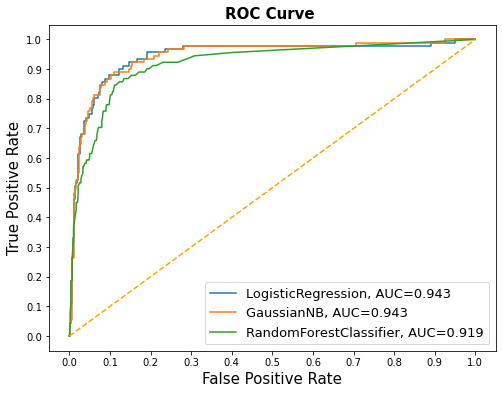

In [21]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve ', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [22]:
classifierTap = LogisticRegression()
classifierTap.fit(X_train, y_train) 

LogisticRegression()

Accuracy of logistic regression classifier on test set: 0.93
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       603
           1       0.74      0.68      0.71        91

    accuracy                           0.93       694
   macro avg       0.85      0.82      0.83       694
weighted avg       0.92      0.93      0.93       694



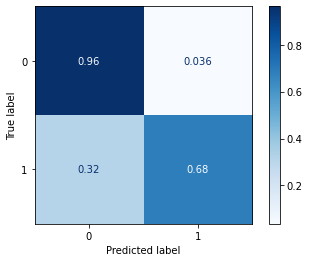

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

y_pred = classifierTap.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifierTap.score(X_test, y_test)))
confusionMatrix = confusion_matrix(y_test, y_pred, normalize='true')
print(classification_report(y_test, y_pred))
disp = plot_confusion_matrix(classifierTap, X_test, y_test,cmap=plt.cm.Blues,normalize='true')


In [24]:
import pickle
pickle_out = open("classifierTap.pkl","wb")
pickle.dump(classifierTap, pickle_out)
pickle_out.close()

In [25]:
#Notes on the Report:
#Precision 0: TN/(TN+FN) of those predicted with out the disease, which how many really do not have it.
#Precision 1: TP/(TP+FP) of those predicted with the disease, which how many really had it.
#Recall 0: TN/(TN+FP) of those that dont have the disease how many were predicted with out the disease
#Recall 1: TP/(TP+FN) of those that have the disease how many were predicted with the disease
#Accuracy: TP+TN/(TP+TN+FP+FN), how many were classified correctly.
#For early diagnosis we would like to focus on recall 1 to be high. People with early stages of the disease should diagnose
#Few false negatives.

In [26]:
# Classification for each quantile
#import numpy as np
#from sklearn.linear_model import LogisticRegression
#from sklearn import metrics
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
#import matplotlib.pyplot as plt



#X = TapTableN[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
##XTapPerf = np.reshape(XTapPerf, (-1,1))
#TapTableN['PDOn']= TapTableN['diagnosis-year']
#Y=TapTableN['PDOn'].to_numpy()
#Y[Y!=0] = 1
#print('Number of samples with the disease is: {:.2f}'.format(np.sum(Y)))
#print('Number of total samples: {:.2f}'.format(len(Y)))
##array_sum = np.sum(X)
##array_has_nan = np.isnan(array_sum)
##print(array_has_nan)
#X = X.astype(np.float64)
#Y = Y.astype(np.float64)
#X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.3, random_state=0)

#print(X)
#print(Y)
#print(y_train.shape)

#X_train = X_train.astype(np.float64)
#y_train = y_train.astype(np.float64)
#X_test = X_test.astype(np.float64)
#y_test = y_test.astype(np.float64)

#Training logistic regression
#logreg = LogisticRegression()
#logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

#confusionMatrix = confusion_matrix(y_test, y_pred, normalize='true')
#print(confusionMatrix)
#print(classification_report(y_test, y_pred))
#disp = plot_confusion_matrix(logreg, X_test, y_test,cmap=plt.cm.Blues,normalize='true')


#Notes on the Report:
#Precision 0: TN/(TN+FN) of those predicted with out the disease, which how many really do not have it.
#Precision 1: TP/(TP+FP) of those predicted with the disease, which how many really had it.
#Recall 0: TN/(TN+FP) of those that dont have the disease how many were predicted with out the disease
#Recall 1: TP/(TP+FN) of those that have the disease how many were predicted with the disease
#Accuracy: TP+TN/(TP+TN+FP+FN), how many were classified correctly.
#For early diagnosis we would like to focus on recall 1 to be high. People with early stages of the disease should diagnose
#Few false negatives.

In [27]:
##Plotting ROC Curve

##Calculate probabilities. Notice that this is different than evaluating the predict y_pred
#y_prob = logreg.predict_proba(X_test)
#y_prob1 = y_prob[:, 1]

#fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob1)
#roc_auc = metrics.auc(fpr, tpr)

#plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()

##Finding the best threshold
#print(threshold[np.argmax(tpr - fpr)])
#print(tpr[np.argmax(tpr - fpr)])
#print(fpr[np.argmax(tpr - fpr)])
#NewThrh=threshold[np.argmax(tpr - fpr)]
#y_probNew = (logreg.predict_proba(X_test)[:,1] >= NewThrh).astype(bool)
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test, y_probNew)

## Using only people before taking medication


In [28]:
#TapTableB = TapTableN[TapTableN['medTimepoint'] != "Just after Parkinson medication (at your best)"] 
#TapTableC = TapTableB[TapTableB['medTimepoint'] != "Another time"] 

#XX = TapTableC[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
#YY=TapTableC['PDOn'].to_numpy()
#YY[YY!=0] = 1

#XX_train, XX_test, yy_train, yy_test = train_test_split(XX,YY , test_size=0.3, random_state=1)

##Training logistic regression
#logregC = LogisticRegression()
#logregC.fit(XX_train, yy_train)
#yy_predC = logregC.predict(XX_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregC.score(XX_test, yy_test)))
#confusionMatrixC = confusion_matrix(yy_test, yy_predC)
#print(confusionMatrixC)
#print(classification_report(yy_test, yy_predC))
#dispC = plot_confusion_matrix(logregC, XX_test, yy_test,cmap=plt.cm.Blues)



In [29]:
#'TapPerform', 'age','Male'
a=classifierTap.predict([[100,40,0]])
a

array([0])

<AxesSubplot:xlabel='YearsPD', ylabel='TapPerform'>

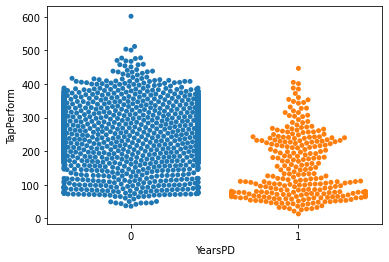

In [30]:
import seaborn as sns
sns.swarmplot(data=TapTableN, x="YearsPD", y="TapPerform")

<AxesSubplot:xlabel='YearsPD', ylabel='age'>

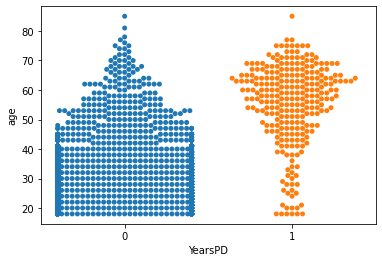

In [31]:
sns.swarmplot(data=TapTableN, x="YearsPD", y="age")

In [6]:
sns.swarmplot(data=TapTableN, x="YearsPD", y="Male")

NameError: name 'sns' is not defined

In [ ]:
##Plotting ROC Curve

##Calculate probabilities. Notice that this is different than evaluating the predict y_pred
#y_probC = logregC.predict_proba(XX_test)
#y_prob1C = y_probC[:, 1]

#fprC, tprC, thresholdC = metrics.roc_curve(yy_test, y_prob1C)
#roc_aucC = metrics.auc(fprC, tprC)

#plt.title('Receiver Operating Characteristic')
#plt.plot(fprC, tprC, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()
##Saving this for using the new threshold
##y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3
##print(fprC)
##print(fpr)

## Graph to see time dependency

In [ ]:
#Prob = logreg.predict_proba(X)
#ProbOfPD=Prob[:, 1]
#Ind=(TapTableN["diagnosis-year"]!=0)
#YearsPD=TapTableN["diagnosis-year"]
#nd=(YearsPD!=0)
#YearsPD[Ind]=(2015-YearsPD[Ind])
#plt.scatter(YearsPD, ProbOfPD, c="g", alpha=0.5, marker=r'$\clubsuit$',
#            label="Luck")
#plt.xlim([-0.5, 20])
#print(ProbOfPD[42])
#print(YearsPD[42])
##TapTableN["TimeDis"][Ind]=(2015-TapTableN["diagnosis-year"][Ind])
##print(TapTableN["age"][72])

## Classifying using diagnostic year as starting point of the disease

In [ ]:
#Let us look at a histogram of the diagnosis year and find quantiles


#Bol=TapTableN["diagnosis-year"]!=0 
#Diagnosis=TapTableN["diagnosis-year"][Bol]
#Bol2=Diagnosis>1960
#Diagnosis= 2015-Diagnosis[Bol2]
#print(Diagnosis)
##hist = Diagnosis.hist(bins=10)
#YearsDiaQuant=Diagnosis.quantile([.25, .5, 0.75])

##Drop values were diagnosis year does not make sense
#Diagnosis = Diagnosis[Diagnosis > 15]
#print(Diagnosis)




In [ ]:
#'TapPerform', 'age','Male'
a=classifierTap.predict([[400,56,1]])
a
